# Imports

In [1]:
import shap
import lime.lime_tabular
import optuna
import xgboost
import lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, learning_curve
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
confusion_matrix,
classification_report,
roc_auc_score,
accuracy_score,
roc_curve,
recall_score,
precision_score,
f1_score,
make_scorer
)
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')

print("-----Imports Successful-----")

-----Imports Successful-----


# Loading data

In [2]:
data = pd.read_csv("/kaggle/input/customer-churn-prediction-business-dataset/customer_churn_business_dataset.csv")
df = pd.DataFrame(data)
df.head()

customer_id  gender  age     country      city customer_segment  \
0  CUST_00001    Male   68  Bangladesh    London              SME   
1  CUST_00002  Female   57      Canada    Sydney       Individual   
2  CUST_00003    Male   24     Germany  New York              SME   
3  CUST_00004    Male   49   Australia     Dhaka       Individual   
4  CUST_00005    Male   65  Bangladesh     Delhi       Individual   

   tenure_months signup_channel contract_type  monthly_logins  ...  \
0             22            Web       Monthly              26  ...   
1              9         Mobile       Monthly               7  ...   
2             58            Web        Yearly              19  ...   
3             19         Mobile        Yearly              34  ...   
4             52            Web       Monthly              20  ...   

   avg_resolution_time  complaint_type  csat_score  escalations  \
0            13.354360         Service         4.0            0   
1            25.140088         Billing         2.0            0   
2            27.572928         Service         3.0            0   
3            26.420822       Technical         5.0            1   
4            26.674579       Technical         4.0            0   

   email_open_rate  marketing_click_rate  nps_score survey_response  \
0             0.71                  0.40         27       Satisfied   
1             0.78                  0.33        -19         Neutral   
2             0.35                  0.49         80         Neutral   
3             0.83                  0.15        100         Neutral   
4             0.65                  0.44         21     Unsatisfied   

   referral_count churn  
0               1     0  
1               2     1  
2               1     0  
3               0     0  
4               1     0  

[5 rows x 32 columns]

In [3]:
print("="*20)
print(df.info())
print("="*20)
print(df.isnull().sum())
print("="*20)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  object 
 1   gender                  10000 non-null  object 
 2   age                     10000 non-null  int64  
 3   country                 10000 non-null  object 
 4   city                    10000 non-null  object 
 5   customer_segment        10000 non-null  object 
 6   tenure_months           10000 non-null  int64  
 7   signup_channel          10000 non-null  object 
 8   contract_type           10000 non-null  object 
 9   monthly_logins          10000 non-null  int64  
 10  weekly_active_days      10000 non-null  int64  
 11  avg_session_time        10000 non-null  float64
 12  features_used           10000 non-null  int64  
 13  usage_growth_rate       10000 non-null  float64
 14  last_login_days_ago     10000 non-null 

# EDA

In [4]:
def auto_eda(
        df,
        n_cols: int = 2, 
        plot_type: str = 'hist',
        max_features: int | None = None,
        max_unique_for_count: int = 15,
        figsize_per_row: float = 3,
        pair_max_features: int | None = 5,
        target: str | None = None,
        sample_threshold: int = 50000,
        sample_size: int = 10000,
    ):
    
    
    print("Auto-EDA Function Running.")
    pt = plot_type.lower()   # normalize once

    
    if pt == 'pairplot':
        # numeric cols
        num_cols = df.select_dtypes(include=np.number).columns.tolist()
        if len(num_cols) == 0:
            raise ValueError("No numeric columns available for pairplot.")

        # limit number of features for pairplot
        if (pair_max_features is not None) and (len(num_cols) > pair_max_features):
            num_cols = num_cols[:pair_max_features]
            print(f"Using these numeric columns for pairplot: {num_cols}")

        # sampling for big data
        if len(df) > sample_threshold:
            df_small = df.sample(n=min(sample_size, len(df)), random_state=42)
            print(f"Sampling {len(df_small)} rows for pairplot (dataset too large).")
        else:
            df_small = df

        # columns to include
        plot_cols = num_cols.copy()

        # optional hue
        hue = None
        if target is not None and target in df_small.columns:
            target_series = df_small[target]
            if (target_series.dtype == 'object') or (target_series.nunique() <= 20):
                hue = target
                if target not in plot_cols:
                    plot_cols.append(target)
                print(f"Using '{target}' as hue in pairplot.")

        sns.pairplot(df_small[plot_cols], hue=hue)
        plt.show()
        return  # important: skip rest of function

    if pt in ['hist', 'box', 'violin', 'bar']:
        # numeric columns
        cols = df.select_dtypes(include=np.number).columns.tolist()
        if len(cols) == 0:
            raise ValueError("No numeric columns found for this plot type.")

        if (max_features is not None) and (len(cols) > max_features):
            cols = cols[:max_features]
            print(f"Plotting using numeric columns (truncated): {cols}")

    elif pt == 'count':
        # categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        if len(cat_cols) == 0:
            raise ValueError("No categorical columns found for count plot.")

        cols = []
        skipped = []

        for col in cat_cols:
            n_unique = df[col].nunique(dropna=True)
            if n_unique <= max_unique_for_count:
                cols.append(col)
            else:
                skipped.append((col, n_unique))

        if skipped:
            print("Skipping high-cardinality columns for countplot (too many unique values):")
            for c, n_u in skipped:
                print(f"  - {c}: {n_u} unique values")

        if len(cols) == 0:
            raise ValueError(
                f"No categorical columns with <= {max_unique_for_count} unique values for countplot."
            )

        if (max_features is not None) and (len(cols) > max_features):
            cols = cols[:max_features]
            print(f"Plotting using categorical columns (truncated): {cols}")

    elif pt == 'target':
        if target is None or target not in df.columns:
            raise ValueError("For plot_type='target', you must provide a valid target column name.")

        # separate numeric / categorical features excluding target itself
        num_cols = df.select_dtypes(include=np.number).columns.tolist()
        if target in num_cols:
            num_cols.remove(target)

        cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        if target in cat_cols:
            cat_cols.remove(target)

        cols = num_cols + cat_cols
        if len(cols) == 0:
            raise ValueError("No features available for target-based plots.")

        if (max_features is not None) and (len(cols) > max_features):
            cols = cols[:max_features]
            print(f"Target plots will use (truncated): {cols}")
    else:
        raise ValueError(f"Unsupported plot_type: {plot_type}")

    n_features = len(cols)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * figsize_per_row))
    axes = np.array(axes).reshape(-1)

    for idx, col in enumerate(cols):
        ax = axes[idx]

        if pt == 'hist':
            sns.histplot(
                data=df[col],
                kde=True,
                ax=ax
            )
            ax.set_title(f"Distribution of {col}")
            ax.set_ylabel("Count")

        elif pt == 'box':
            sns.boxplot(
                y=df[col],
                ax=ax
            )
            ax.set_title(f"Box plot of {col}")

        elif pt == 'violin':
            sns.violinplot(
                y=df[col],
                ax=ax
            )
            ax.set_title(f"Violin plot of {col}")

        elif pt == 'bar':
            sns.barplot(
                x=df.index,
                y=df[col],
                ax=ax
            )
            ax.set_title(f"Bar plot of {col}")

        elif pt == 'count':
            sns.countplot(
                x=df[col],
                ax=ax
            )
            ax.set_title(f"Count plot of {col}")
            ax.tick_params(axis='x', rotation=45)

        elif pt == 'target':
            if target is None:
                raise ValueError("target must be provided for plot_type='target'.")

            t = df[target]
            x = df[col]

            target_is_numeric = np.issubdtype(t.dtype, np.number)
            feature_is_numeric = np.issubdtype(x.dtype, np.number)

            # 1) numeric feature vs numeric target -> scatter
            if target_is_numeric and feature_is_numeric:
                sns.scatterplot(
                    x=x,
                    y=t,
                    ax=ax
                )
                ax.set_xlabel(col)
                ax.set_ylabel(target)
                ax.set_title(f"{col} vs {target}")

            # 2) categorical feature vs numeric target -> boxplot
            elif target_is_numeric and not feature_is_numeric:
                sns.boxplot(
                    x=x,
                    y=t,
                    ax=ax
                )
                ax.set_xlabel(col)
                ax.set_ylabel(target)
                ax.set_title(f"{target} by {col}")
                ax.tick_params(axis='x', rotation=45)

            # 3) numeric feature vs categorical target -> boxplot
            elif not target_is_numeric and feature_is_numeric:
                sns.boxplot(
                    x=t,
                    y=x,
                    ax=ax
                )
                ax.set_xlabel(target)
                ax.set_ylabel(col)
                ax.set_title(f"{col} by {target}")
                ax.tick_params(axis='x', rotation=45)

            # 4) both categorical -> countplot with hue
            else:
                sns.countplot(
                    x=x,
                    hue=t,
                    ax=ax
                )
                ax.set_xlabel(col)
                ax.set_ylabel("Count")
                ax.set_title(f"{col} vs {target} (count with hue)")
                ax.tick_params(axis='x', rotation=45)

    # turn off unused axes
    last_idx = len(cols) - 1
    for k in range(last_idx + 1, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

Auto-EDA Function Running.


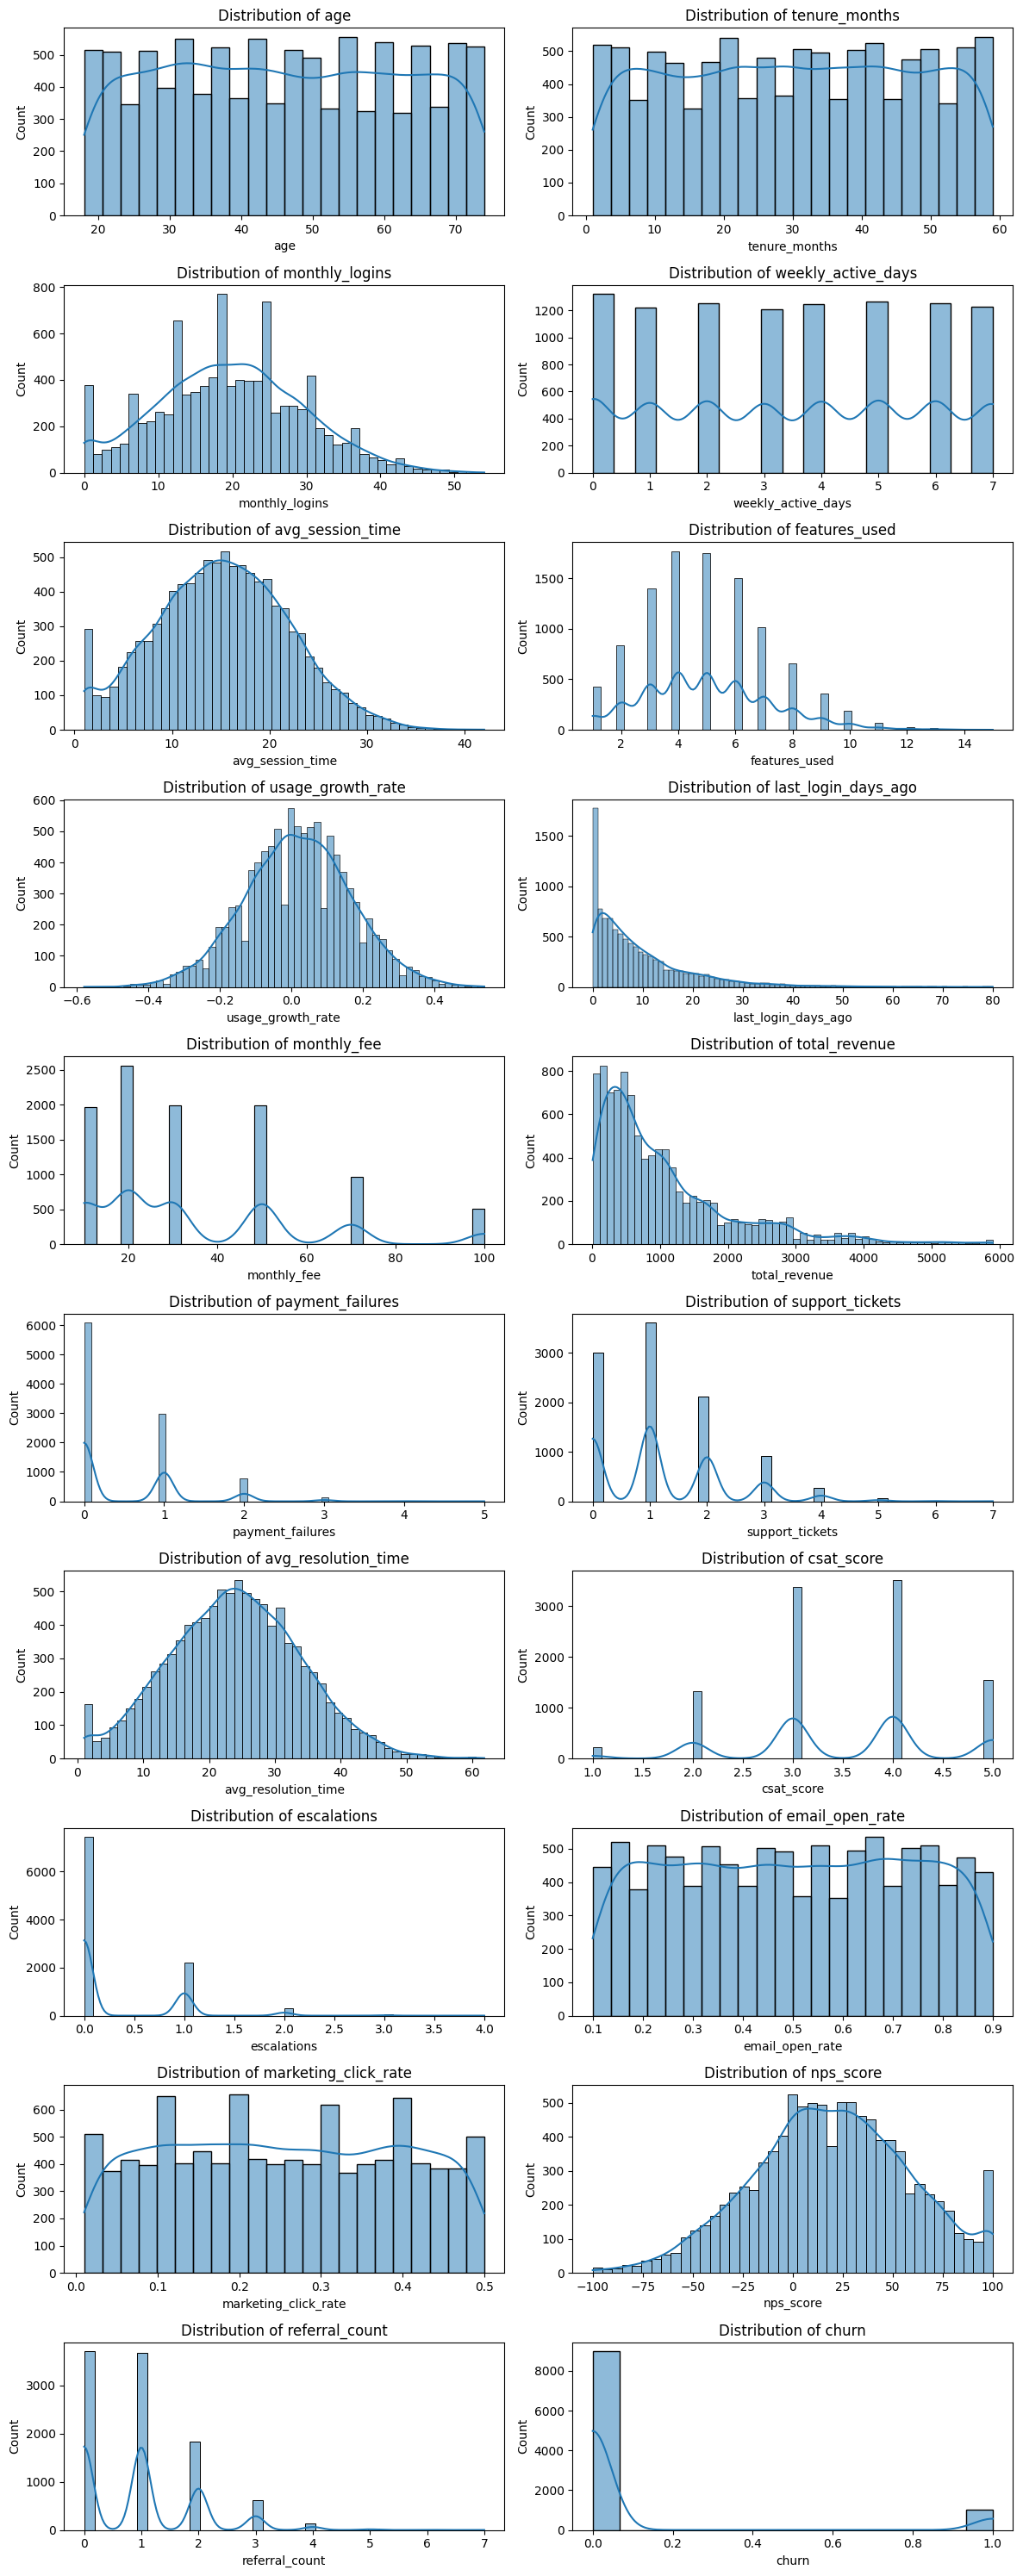

In [5]:
auto_eda(df=df, plot_type = 'hist')

Auto-EDA Function Running.
Skipping high-cardinality columns for countplot (too many unique values):
  - customer_id: 10000 unique values


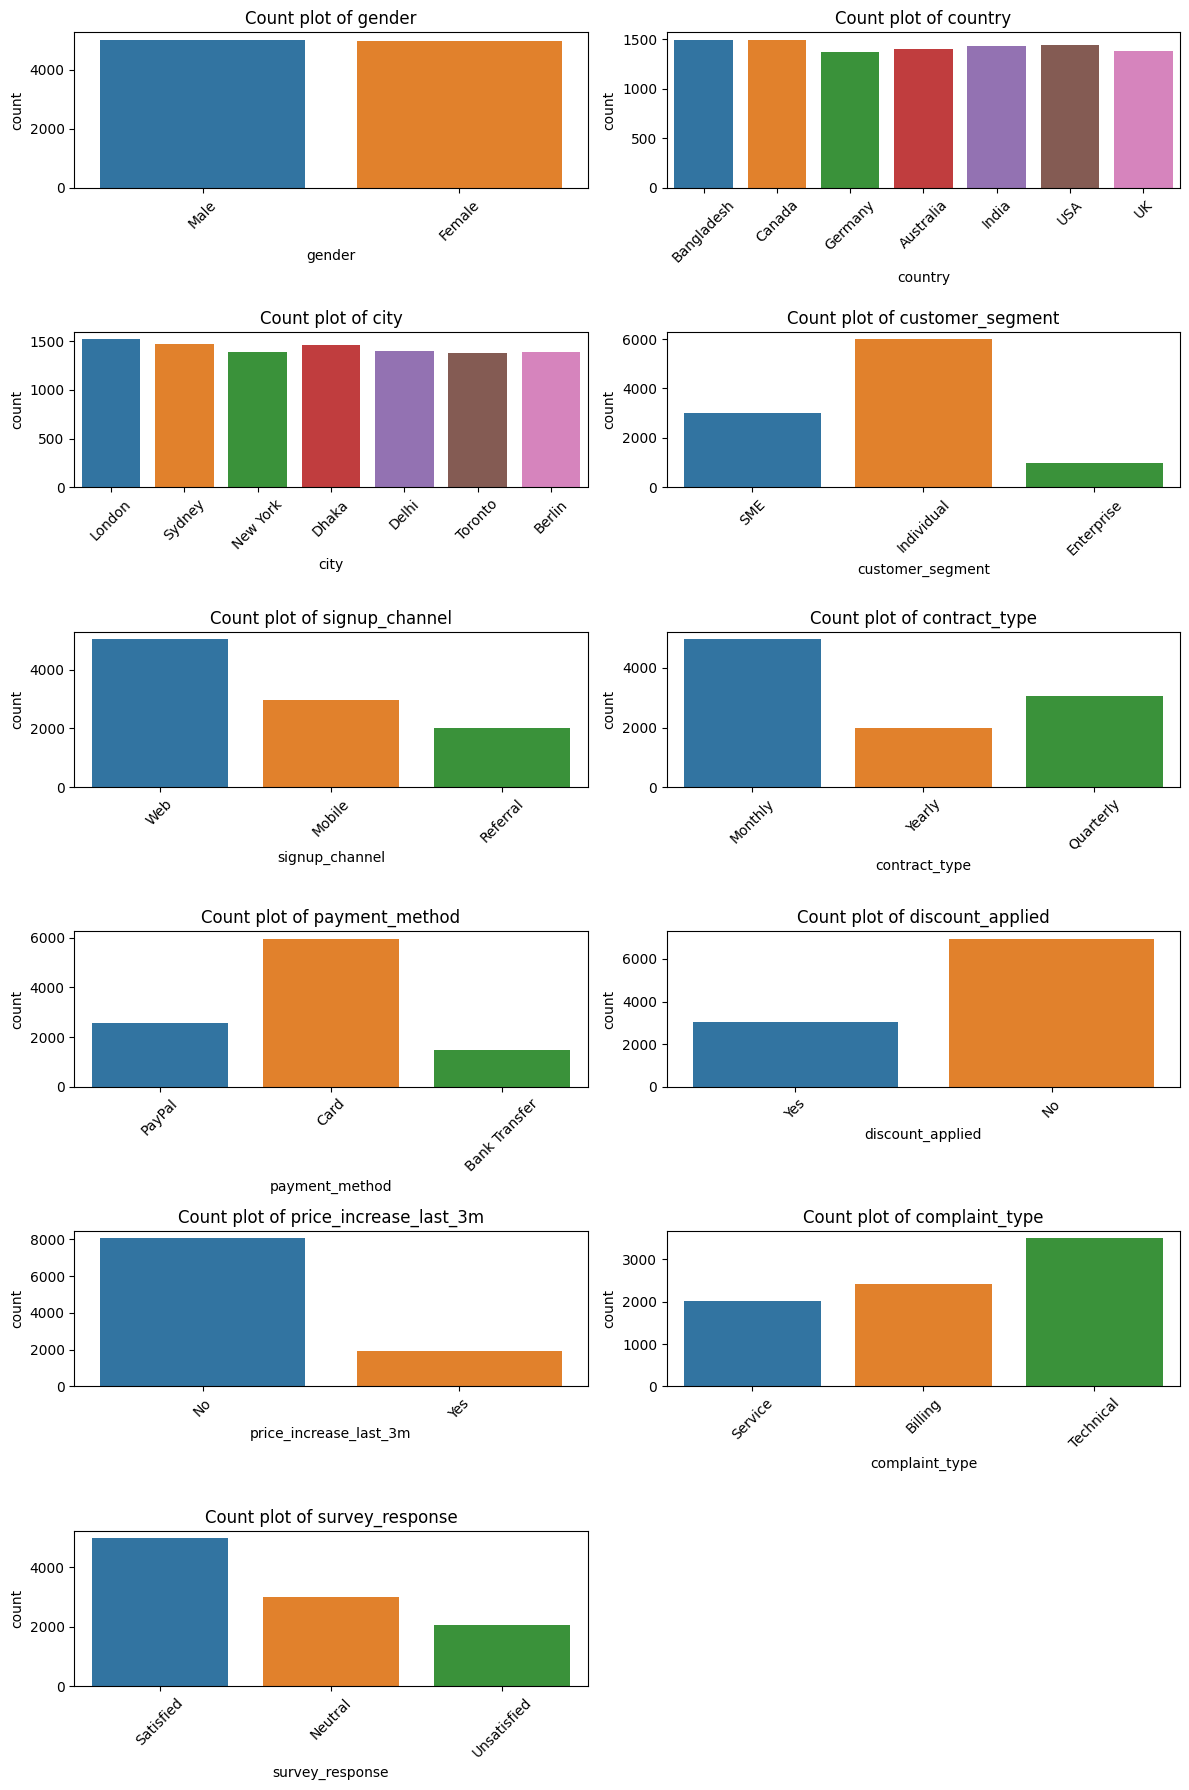

In [6]:
auto_eda(df=df, plot_type = 'count')

Auto-EDA Function Running.


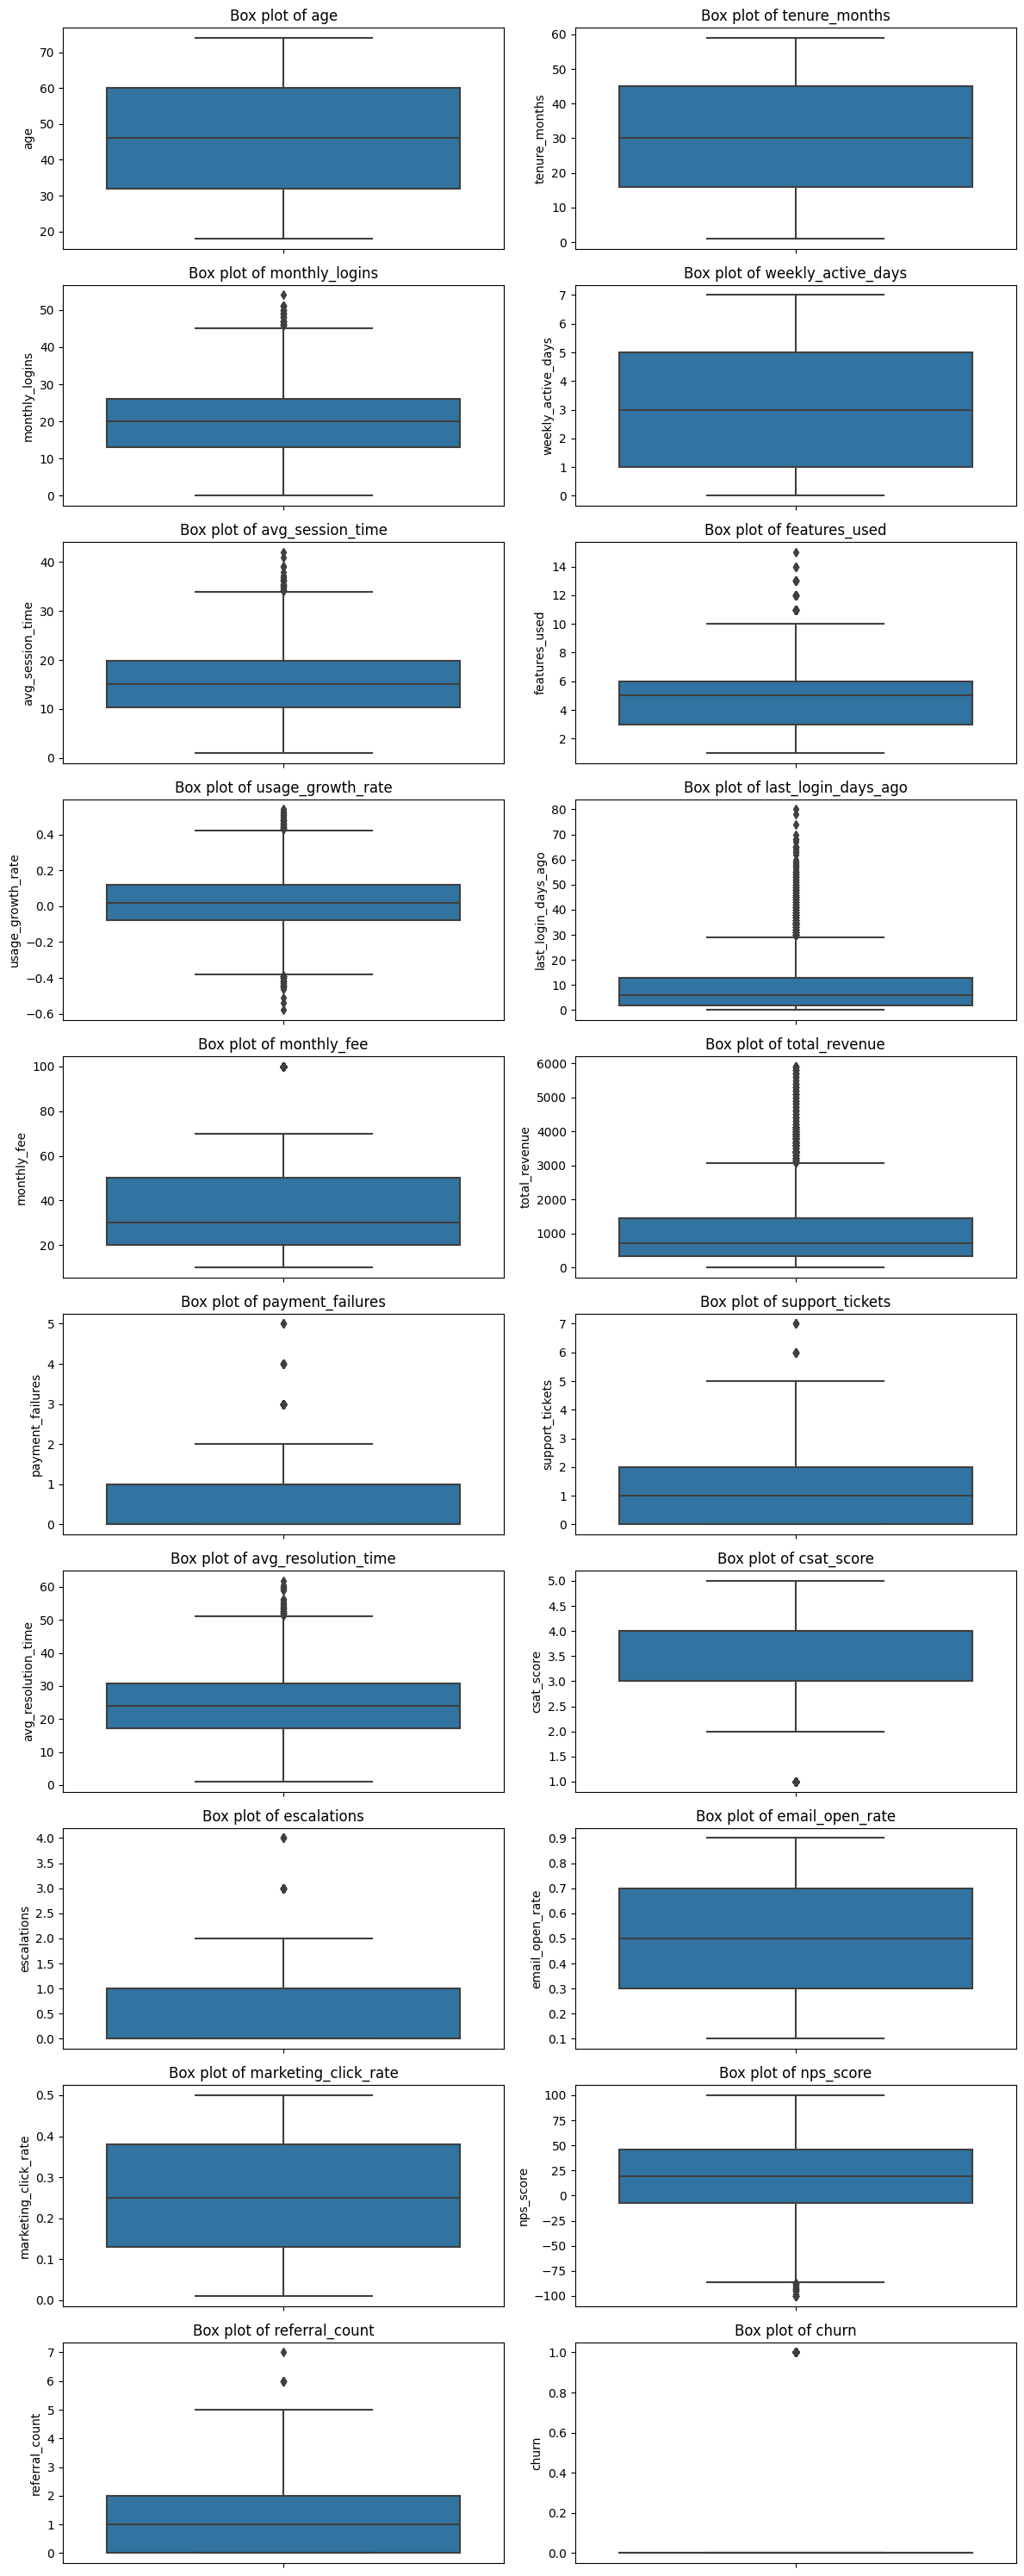

In [7]:
auto_eda(df=df, plot_type = 'box')

Auto-EDA Function Running.


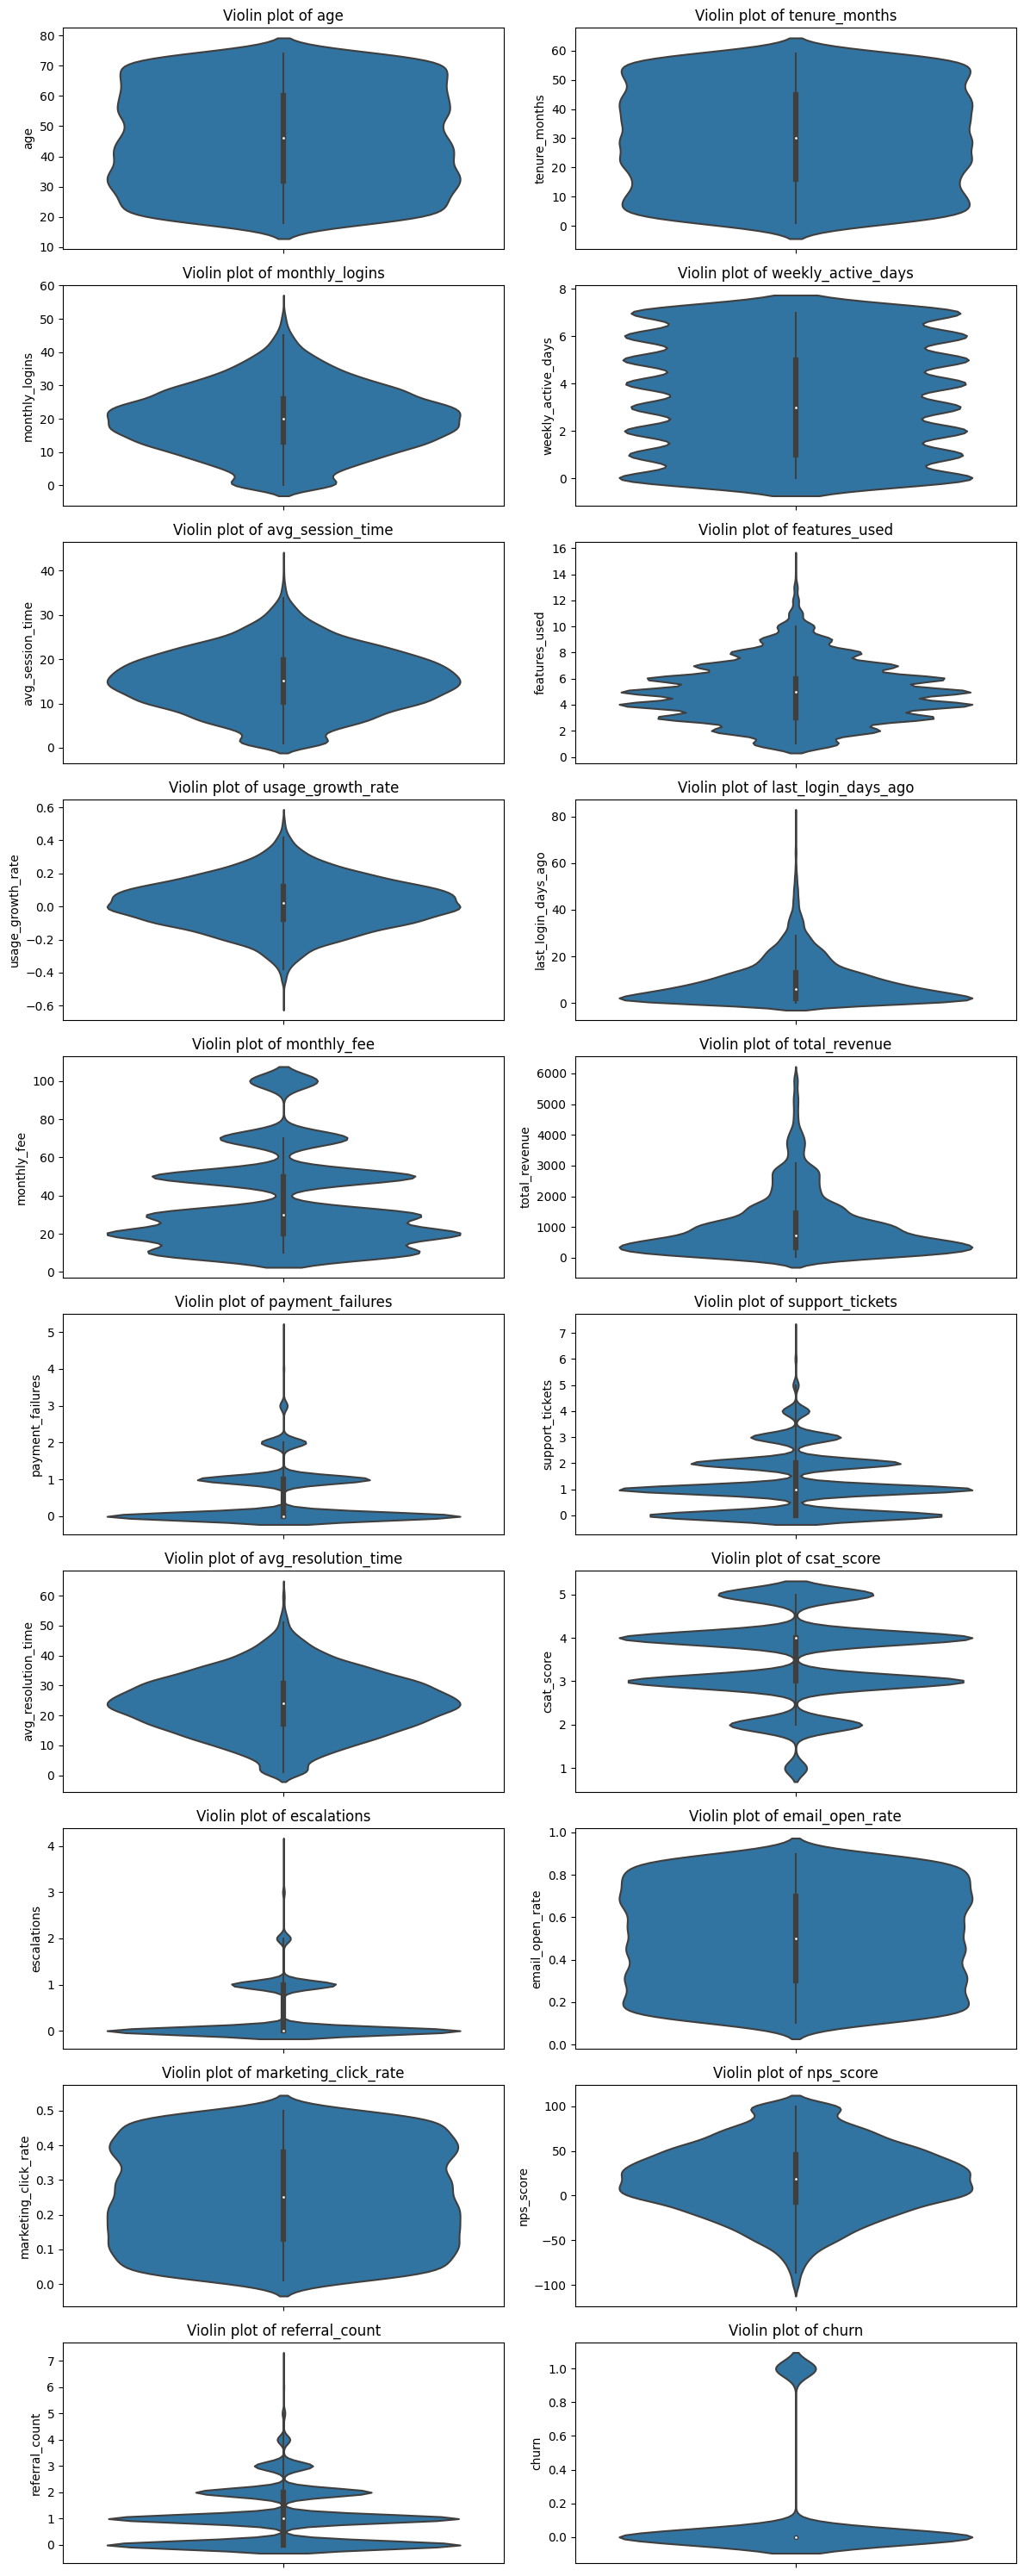

In [8]:
auto_eda(df=df, plot_type = 'violin')

Auto-EDA Function Running.
Using these numeric columns for pairplot: ['age', 'tenure_months', 'monthly_logins', 'weekly_active_days', 'avg_session_time']
Using 'churn' as hue in pairplot.


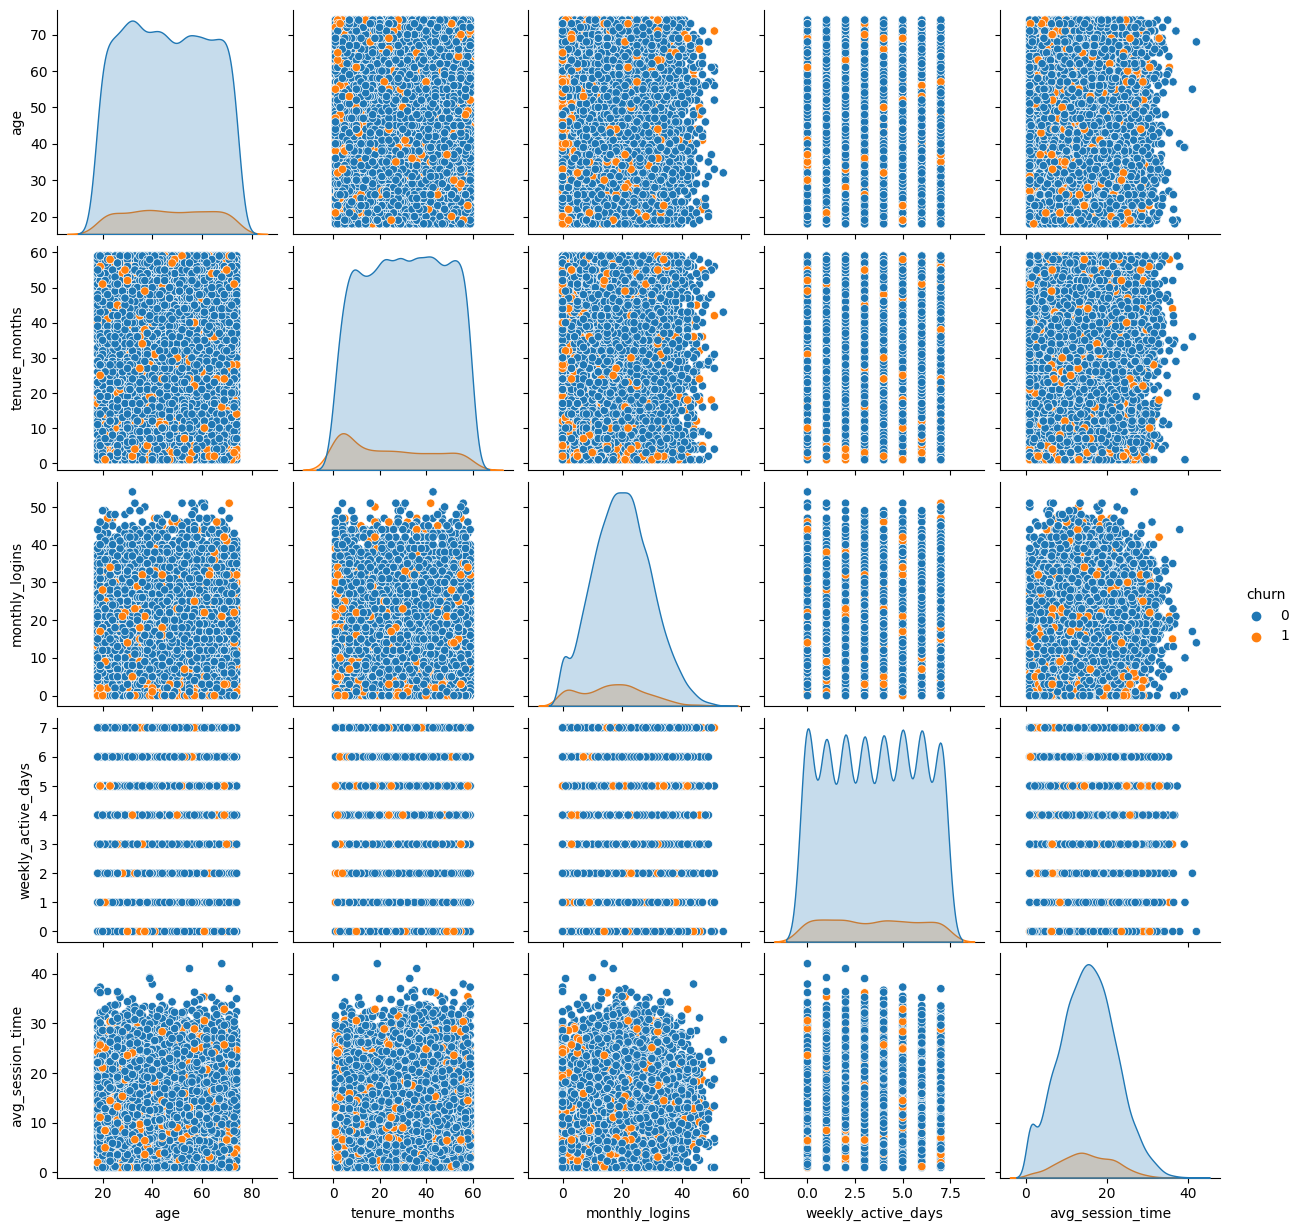

In [9]:
auto_eda(df=df, plot_type = 'pairplot', target = 'churn')

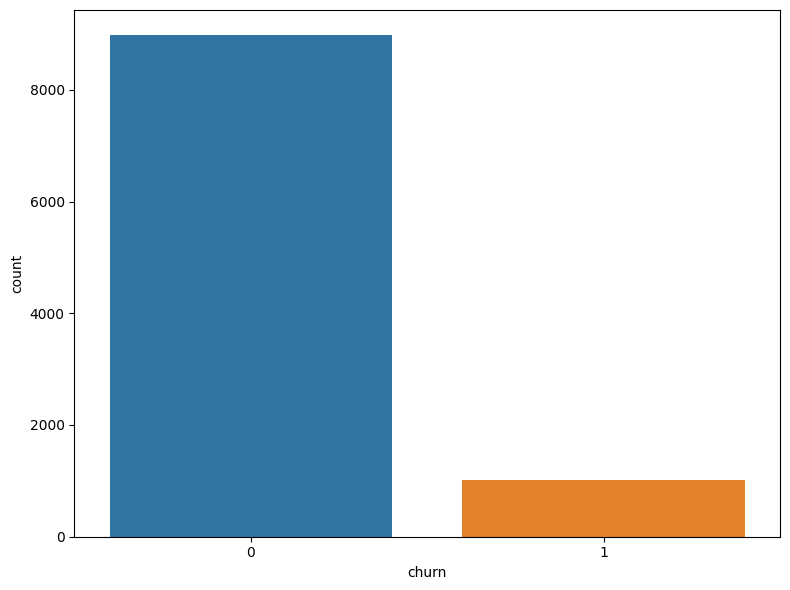

In [10]:
plt.figure(figsize=(8,6))
sns.countplot(
    data = df,
    x = 'churn'
)
plt.tight_layout()
plt.show()

# Filling missing values 

In [11]:
new_complaint = 'others'

df['complaint_type'] = df['complaint_type'].fillna(value = new_complaint)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  object 
 1   gender                  10000 non-null  object 
 2   age                     10000 non-null  int64  
 3   country                 10000 non-null  object 
 4   city                    10000 non-null  object 
 5   customer_segment        10000 non-null  object 
 6   tenure_months           10000 non-null  int64  
 7   signup_channel          10000 non-null  object 
 8   contract_type           10000 non-null  object 
 9   monthly_logins          10000 non-null  int64  
 10  weekly_active_days      10000 non-null  int64  
 11  avg_session_time        10000 non-null  float64
 12  features_used           10000 non-null  int64  
 13  usage_growth_rate       10000 non-null  float64
 14  last_login_days_ago     10000 non-null 

# Target Encoding 

In [13]:
df.head()

customer_id  gender  age     country      city customer_segment  \
0  CUST_00001    Male   68  Bangladesh    London              SME   
1  CUST_00002  Female   57      Canada    Sydney       Individual   
2  CUST_00003    Male   24     Germany  New York              SME   
3  CUST_00004    Male   49   Australia     Dhaka       Individual   
4  CUST_00005    Male   65  Bangladesh     Delhi       Individual   

   tenure_months signup_channel contract_type  monthly_logins  ...  \
0             22            Web       Monthly              26  ...   
1              9         Mobile       Monthly               7  ...   
2             58            Web        Yearly              19  ...   
3             19         Mobile        Yearly              34  ...   
4             52            Web       Monthly              20  ...   

   avg_resolution_time  complaint_type  csat_score  escalations  \
0            13.354360         Service         4.0            0   
1            25.140088         Billing         2.0            0   
2            27.572928         Service         3.0            0   
3            26.420822       Technical         5.0            1   
4            26.674579       Technical         4.0            0   

   email_open_rate  marketing_click_rate  nps_score survey_response  \
0             0.71                  0.40         27       Satisfied   
1             0.78                  0.33        -19         Neutral   
2             0.35                  0.49         80         Neutral   
3             0.83                  0.15        100         Neutral   
4             0.65                  0.44         21     Unsatisfied   

   referral_count churn  
0               1     0  
1               2     1  
2               1     0  
3               0     0  
4               1     0  

[5 rows x 32 columns]

In [39]:
df_train_enc = df.copy()

target_col = 'churn'
df_train_enc[target_col] = pd.to_numeric(df_train_enc[target_col], errors='coerce')

cate_cols = df_train_enc.select_dtypes(include=['object', 'category']).columns.tolist()

smoothing = 20
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in cate_cols:
    enc_col = col + '_enc'
    df_train_enc[enc_col] = np.nan 

    for train_idx, val_idx in kf.split(df_train_enc):
        train_fold = df_train_enc.iloc[train_idx]
        val_fold = df_train_enc.iloc[val_idx]

        fold_global_mean = train_fold[target_col].mean()

        stats = train_fold.groupby(col)[target_col].agg(
            mean_target='mean',
            counts='count'
        )

        smooth = (stats['mean_target'] * stats['counts'] + fold_global_mean * smoothing) / (
            stats['counts'] + smoothing
        )

        df_train_enc.loc[val_idx, enc_col] = val_fold[col].map(smooth)

    global_mean_full = df_train_enc[target_col].mean()
    df_train_enc[enc_col].fillna(global_mean_full, inplace=True)

encoded_features = [col + '_enc' for col in cate_cols]

num_cols = df_train_enc.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in encoded_features + [target_col]]

final_df = df_train_enc[num_cols + encoded_features + [target_col]]


target_encoding_maps = {}

global_mean = df_train_enc[target_col].mean()

for col in cat_cols:
    stats = df_train_enc.groupby(col)[target_col].agg(
        mean_target='mean',
        counts='count'
    )

    smooth = (
        stats['mean_target'] * stats['counts']
        + global_mean * smoothing
    ) / (stats['counts'] + smoothing)

    target_encoding_maps[col] = smooth.to_dict()


print("Final encoded dataset shape:", final_df.shape)
final_df.head()

Final encoded dataset shape: (10000, 32)


age  tenure_months  monthly_logins  weekly_active_days  avg_session_time  \
0   68             22              26                   7         11.762372   
1   57              9               7                   5         26.846390   
2   24             58              19                   5         23.380065   
3   49             19              34                   7         24.243136   
4   65             52              20                   6         18.872323   

   features_used  usage_growth_rate  last_login_days_ago  monthly_fee  \
0              5               0.06                    7           30   
1              1              -0.28                    2           30   
2              6               0.13                   23           20   
3              2              -0.17                   24           30   
4              2              -0.16                    2           50   

   total_revenue  ...  city_enc  customer_segment_enc  signup_channel_enc  \
0            660  ...  0.093452              0.108341            0.096040   
1            270  ...  0.104821              0.098844            0.102841   
2           1160  ...  0.117008              0.113465            0.100623   
3            570  ...  0.096449              0.097005            0.097491   
4           2600  ...  0.096755              0.098844            0.099887   

   contract_type_enc  payment_method_enc  discount_applied_enc  \
0           0.102313            0.097363              0.098535   
1           0.101659            0.104785              0.103808   
2           0.105725            0.106933              0.108582   
3           0.102724            0.097049              0.098535   
4           0.101659            0.102266              0.103808   

   price_increase_last_3m_enc  complaint_type_enc  survey_response_enc  churn  
0                    0.099319            0.095068             0.096494      0  
1                    0.101236            0.100325             0.093936      1  
2                    0.104267            0.099276             0.100907      0  
3                    0.099319            0.108396             0.098911      0  
4                    0.102341            0.102515             0.121347      0  

[5 rows x 32 columns]

# Creating New Features

In [15]:
def create_features(df):
    
    df['engagement_score'] = df['weekly_active_days'] * df['avg_session_time']
    
    df['login_intensity'] = df['monthly_logins'] * (df['weekly_active_days'] + 1)
    
    df['feature_adapotion_rate'] = df['features_used'] / df['tenure_months']
    
    df['usage_momentum'] = df['usage_growth_rate'] * df['tenure_months']
    
    df['revenue_per_feature'] = df['total_revenue'] / (df['features_used'] + 1)
    
    df['effective_cost_per_login'] = df['monthly_fee'] * (df['monthly_logins'] + 1)
    
    df['value_gap'] = df['monthly_fee'] - (df['features_used'] * df['avg_session_time'] / 100)
    
    df['tenure_to_revenue_ratio'] = df['tenure_months'] / (df['total_revenue'] / df['monthly_fee'] + 1)
    
    df['silent_complainer'] = (
    (df['support_tickets'] == 0) & 
    (df['nps_score'] < 5) & 
    (df['last_login_days_ago'] > 14)
        ).astype(int)
    
    return df

df_final = create_features(final_df)
df_final.head()

age  tenure_months  monthly_logins  weekly_active_days  avg_session_time  \
0   68             22              26                   7         11.762372   
1   57              9               7                   5         26.846390   
2   24             58              19                   5         23.380065   
3   49             19              34                   7         24.243136   
4   65             52              20                   6         18.872323   

   features_used  usage_growth_rate  last_login_days_ago  monthly_fee  \
0              5               0.06                    7           30   
1              1              -0.28                    2           30   
2              6               0.13                   23           20   
3              2              -0.17                   24           30   
4              2              -0.16                    2           50   

   total_revenue  ...  churn  engagement_score  login_intensity  \
0            660  ...      0         82.336604              208   
1            270  ...      1        134.231948               42   
2           1160  ...      0        116.900325              114   
3            570  ...      0        169.701954              272   
4           2600  ...      0        113.233937              140   

   feature_adapotion_rate  usage_momentum  revenue_per_feature  \
0                0.227273            1.32           110.000000   
1                0.111111           -2.52           135.000000   
2                0.103448            7.54           165.714286   
3                0.105263           -3.23           190.000000   
4                0.038462           -8.32           866.666667   

   effective_cost_per_login  value_gap  tenure_to_revenue_ratio  \
0                       810  29.411881                 0.956522   
1                       240  29.731536                 0.900000   
2                       400  18.597196                 0.983051   
3                      1050  29.515137                 0.950000   
4                      1050  49.622554                 0.981132   

   silent_complainer  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 41 columns]

# Feature transformation

In [16]:
log_features = ['monthly_logins', 'total_revenue', 'avg_session_time', 
                'support_tickets', 'referral_count', 'tenure_months']

for feat in log_features:
    df_final[f'log_{feat}'] = np.log1p(df[feat])


df_final['is_revenue_outlier'] = (df_final['total_revenue'] > df_final['total_revenue'].quantile(0.99)).astype(int)
df_final['is_engagement_outlier'] = (df_final['monthly_logins'] > 500).astype(int)
df_final['is_chronic_support'] = (df_final['support_tickets'] > 20).astype(int)

rank_features = ['csat_score', 'nps_score', 'weekly_active_days']

for feat in rank_features:
    df_final[f'rank_{feat}'] = df_final[feat].rank(pct=True)

scaler = RobustScaler()
scale_features = ['age', 'monthly_fee', 'features_used']

df_final[[f'scaled_{f}' for f in scale_features]] = scaler.fit_transform(df_final[scale_features])

In [17]:
df_final.head()

age  tenure_months  monthly_logins  weekly_active_days  avg_session_time  \
0   68             22              26                   7         11.762372   
1   57              9               7                   5         26.846390   
2   24             58              19                   5         23.380065   
3   49             19              34                   7         24.243136   
4   65             52              20                   6         18.872323   

   features_used  usage_growth_rate  last_login_days_ago  monthly_fee  \
0              5               0.06                    7           30   
1              1              -0.28                    2           30   
2              6               0.13                   23           20   
3              2              -0.17                   24           30   
4              2              -0.16                    2           50   

   total_revenue  ...  log_tenure_months  is_revenue_outlier  \
0            660  ...           3.135494                   0   
1            270  ...           2.302585                   0   
2           1160  ...           4.077537                   0   
3            570  ...           2.995732                   0   
4           2600  ...           3.970292                   0   

   is_engagement_outlier  is_chronic_support  rank_csat_score  rank_nps_score  \
0                      0                   0          0.66850         0.57765   
1                      0                   0          0.08825         0.16475   
2                      0                   0          0.32335         0.93770   
3                      0                   0          0.92235         0.98785   
4                      0                   0          0.66850         0.51665   

   rank_weekly_active_days  scaled_age  scaled_monthly_fee  \
0                  0.93860    0.785714            0.000000   
1                  0.68845    0.392857            0.000000   
2                  0.68845   -0.785714           -0.333333   
3                  0.93860    0.107143            0.000000   
4                  0.81445    0.678571            0.666667   

   scaled_features_used  
0              0.000000  
1             -1.333333  
2              0.333333  
3             -1.000000  
4             -1.000000  

[5 rows x 56 columns]

# spliting the data

In [18]:
X_baseline = df_final.drop(['churn'], axis = 1)
y_baseline = df_final['churn']

X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_baseline, y_baseline, 
                                                                test_size = 0.2, random_state = 42,
                                                               stratify = y_baseline)

# Training Baseline Models

In [19]:
histgbm = HistGradientBoostingClassifier(
    random_state = 42,
    class_weight = 'balanced',
    max_iter = 500,
    max_depth = 4
)

histgbm.fit(X_train_bl, y_train_bl)

hist_preds = histgbm.predict(X_train_bl)
hist_test = histgbm.predict(X_test_bl)

histrec = recall_score(y_test_bl, hist_test)
histpre = precision_score(y_test_bl, hist_test)
histacc = accuracy_score(y_train_bl, hist_preds)
histtacc = accuracy_score(y_test_bl, hist_test)
histroc = roc_auc_score(y_test_bl, hist_test)

print(f"Training accuracy HistGradient: {histacc}")
print("-"*20)
print(f"Testing accuracy HistGradient: {histtacc}")
print("-"*20)
print(f"Recall HistGradient: {histrec}")
print("-"*20)
print(f"Presicion HistGradient: {histpre}")
print("-"*20)
print(f"ROC-AUC-SCORE HistGradient : {histroc}")
print("-"*20)
print(f"Classfication report: \n {classification_report(y_test_bl, hist_test)}")
print("-"*20)
print(f"Confusion matrix: \n {confusion_matrix(y_test_bl, hist_test)}")

Training accuracy HistGradient: 0.976125
--------------------
Testing accuracy HistGradient: 0.8475
--------------------
Recall HistGradient: 0.39705882352941174
--------------------
Presicion HistGradient: 0.30798479087452474
--------------------
ROC-AUC-SCORE HistGradient : 0.6478612603170444
--------------------
Classfication report: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      1796
           1       0.31      0.40      0.35       204

    accuracy                           0.85      2000
   macro avg       0.62      0.65      0.63      2000
weighted avg       0.87      0.85      0.86      2000

--------------------
Confusion matrix: 
 [[1614  182]
 [ 123   81]]


In [20]:
rf = RandomForestClassifier(
    random_state = 42,
    class_weight = 'balanced'
)

rf.fit(X_train_bl, y_train_bl)

rf_preds = rf.predict(X_train_bl)
rf_test = rf.predict(X_test_bl)

rfrec = recall_score(y_test_bl, rf_test)
rfpre = precision_score(y_test_bl, rf_test)
rfacc = accuracy_score(y_train_bl, rf_preds)
rftacc = accuracy_score(y_test_bl, rf_test)
rfroc = roc_auc_score(y_test_bl, rf_test)

print(f"Training accuracy RandomForest: {rfacc}")
print("-"*20)
print(f"Testing accuracy RandomForest: {rftacc}")
print("-"*20)
print(f"ROC-AUC-SCORE RandomForest : {rfroc}")
print("-"*20)
print(f"Recall RandomForest: {rfrec}")
print("-"*20)
print(f"Presicion RandomForest: {rfpre}")
print("-"*20)
print(f"Classfication report: \n {classification_report(y_test_bl, rf_test)}")
print("-"*20)
print(f"Confusion matrix: \n {confusion_matrix(y_test_bl, rf_test)}")

Training accuracy RandomForest: 1.0
--------------------
Testing accuracy RandomForest: 0.896
--------------------
ROC-AUC-SCORE RandomForest : 0.5010589982095288
--------------------
Recall RandomForest: 0.004901960784313725
--------------------
Presicion RandomForest: 0.16666666666666666
--------------------
Classfication report: 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1796
           1       0.17      0.00      0.01       204

    accuracy                           0.90      2000
   macro avg       0.53      0.50      0.48      2000
weighted avg       0.82      0.90      0.85      2000

--------------------
Confusion matrix: 
 [[1791    5]
 [ 203    1]]


In [21]:
df_final['churn'].value_counts()

churn
0    8979
1    1021
Name: count, dtype: int64

# Feature Selection with RFE-CV

Selected features:
Index(['age', 'tenure_months', 'monthly_logins', 'avg_session_time',
       'last_login_days_ago', 'total_revenue', 'payment_failures',
       'csat_score', 'email_open_rate', 'marketing_click_rate', 'nps_score',
       'country_enc', 'city_enc', 'signup_channel_enc', 'contract_type_enc',
       'payment_method_enc', 'complaint_type_enc', 'login_intensity',
       'revenue_per_feature', 'effective_cost_per_login'],
      dtype='object')


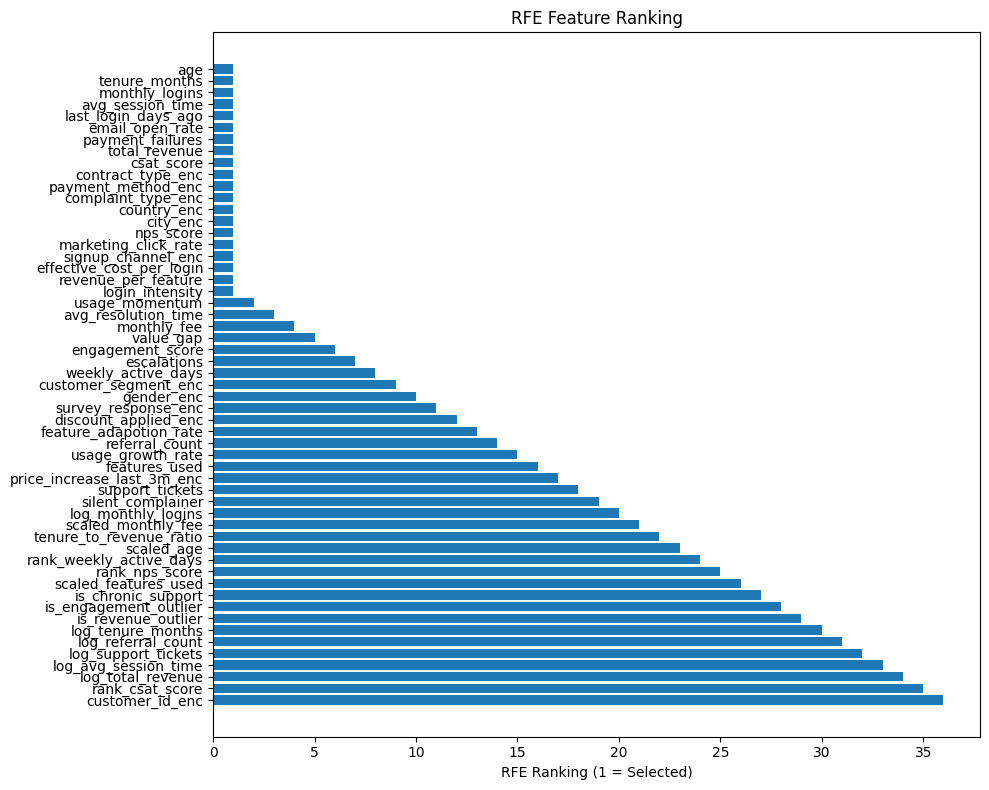

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Optimal number of features: 32
Selected features: Index(['age', 'tenure_months', 'monthly_logins', 'weekly_active_days',
       'avg_session_time', 'last_login_days_ago', 'monthly_fee',
       'total_revenue', 'payment_failures', 'avg_resolution_time',
       'csat_score', 'escalations', 'email_open_rate', 'marketing_click_rate',
       'nps_score', 'gender_enc', 'country_enc', 'city_enc',
       'customer_segment_enc', 'signup_channel_enc', 'contract_type_enc',
       'payment_method_enc', 'discount_applied_enc', 'complaint_type_enc',
       'survey_response_enc', 'engagement_score', 'login_intensity',
       'feature_adapotion_rate', 'usage_momentum', 'revenue_per_feature',
       'effective_cost_per_login', 'value_gap'],
      dtype='object')


In [22]:
estimator = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'aucpr',
    device = 'gpu',
    tree_method = 'hist'
)

n_features = 20

selector = RFE(
    estimator = estimator,
    n_features_to_select = n_features,
    step = 1
)

selector.fit(X_train_bl, y_train_bl)

selected_mask = selector.support_
selected_features = X_baseline.columns[selected_mask]
feature_ranking = selector.ranking_

print("Selected features:")
print(selected_features)

rfe_df = pd.DataFrame({
    "feature": X_baseline.columns,
    "ranking": feature_ranking,
    "selected": selected_mask
})

rfe_df = rfe_df.sort_values(by="ranking", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(rfe_df["feature"], rfe_df["ranking"])
plt.gca().invert_yaxis()  
plt.xlabel("RFE Ranking (1 = Selected)")
plt.title("RFE Feature Ranking")
plt.tight_layout()
plt.show()

scorer = make_scorer(roc_auc_score, needs_proba=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring=scorer,
    n_jobs=-1
)

rfecv.fit(X_train_bl, y_train_bl)

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", X_baseline.columns[rfecv.support_])

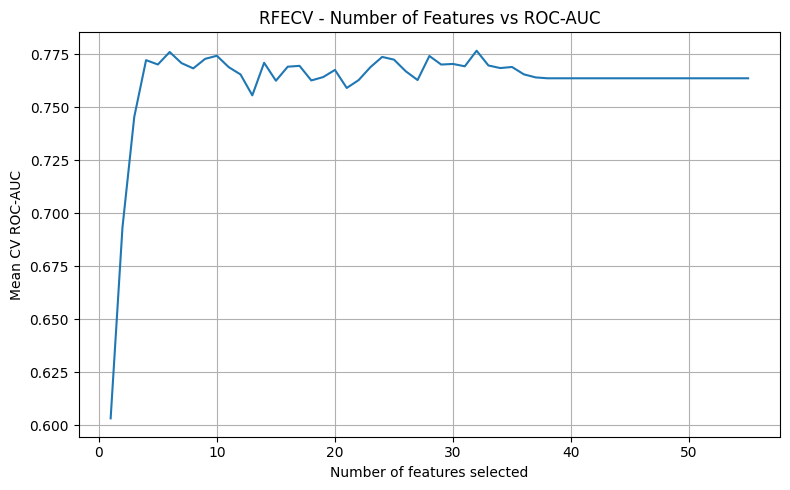

In [23]:
scores = rfecv.cv_results_["mean_test_score"]

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(scores) + 1), 
    scores
)
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV ROC-AUC")
plt.title("RFECV - Number of Features vs ROC-AUC")
plt.grid(True)
plt.tight_layout()
plt.show()

# Training on selected features

In [24]:
X = df_final.drop(['churn'], axis = 1)
y = df_final['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,
                                                               stratify = y)

In [25]:
selected_features = X.columns[rfecv.support_]

print(len(selected_features))
print(selected_features.tolist())

32
['age', 'tenure_months', 'monthly_logins', 'weekly_active_days', 'avg_session_time', 'last_login_days_ago', 'monthly_fee', 'total_revenue', 'payment_failures', 'avg_resolution_time', 'csat_score', 'escalations', 'email_open_rate', 'marketing_click_rate', 'nps_score', 'gender_enc', 'country_enc', 'city_enc', 'customer_segment_enc', 'signup_channel_enc', 'contract_type_enc', 'payment_method_enc', 'discount_applied_enc', 'complaint_type_enc', 'survey_response_enc', 'engagement_score', 'login_intensity', 'feature_adapotion_rate', 'usage_momentum', 'revenue_per_feature', 'effective_cost_per_login', 'value_gap']


In [26]:
X_train_sel = X_train.loc[:, selected_features]
X_test_sel = X_test.loc[:, selected_features]

# Hyperparameter tunining

Commenting the optuna codes to decrease the run time 

In [27]:
'''

def objective_lgbm(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
    }

    lightmodel = LGBMClassifier(
        **params,
        device = 'gpu',
        gpu_device_id = 0,
        gpu_platform_id = 0,
        verbose = -1
    )
    lightmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    preds = lightmodel.predict_proba(X_test)[:,1]
    
    return roc_auc_score(y_test, preds)


study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgbm, n_trials=100)   

print("Best params:", study_lgb.best_params)
print("Best ROC-AUC:", study_lgb.best_value)

'''

'\n\ndef objective_lgbm(trial):\n    params = {\n        "objective": "binary",\n        "metric": "auc",\n        "boosting_type": "gbdt",\n        "verbosity": -1,\n        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),\n        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),\n        "num_leaves": trial.suggest_int("num_leaves", 20, 300),\n        "max_depth": trial.suggest_int("max_depth", -1, 15),\n        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),\n        "subsample": trial.suggest_float("subsample", 0.5, 1.0),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),\n        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),\n        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),\n        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),\n    }\n\n    lightmodel = LGBMClassifier(\n        **params,\n        device = \'gpu\',\n  

In [28]:
'''

def objective_xgb(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),
    }
    xgbmodel = XGBClassifier(
        **params,
        device = 'cuda',
        tree_method = 'hist'
    )
    xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    preds = xgbmodel.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, preds)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=100)

print("Best params:", study_xgb.best_params)
print("Best ROC-AUC:", study_xgb.best_value)

'''

'\n\ndef objective_xgb(trial):\n    params = {\n        "objective": "binary:logistic",\n        "eval_metric": "auc",\n        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),\n        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),\n        "max_depth": trial.suggest_int("max_depth", 3, 15),\n        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),\n        "subsample": trial.suggest_float("subsample", 0.5, 1.0),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),\n        "gamma": trial.suggest_float("gamma", 0, 5),\n        "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),\n        "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),\n    }\n    xgbmodel = XGBClassifier(\n        **params,\n        device = \'cuda\',\n        tree_method = \'hist\'\n    )\n    xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)\n\n    preds = xgbmodel.predict_proba(X_tes

# Building Final Models

In [29]:
final_xgb = XGBClassifier(
    n_estimators = 1905,
    learning_rate = 0.0006830180104830896,
    max_depth = 3,
    subsample = 0.5066373829141722,
    colsample_bytree = 0.7023348196134841,
    gamma = 4.6966738289242995,
    alpha = 7.46297474393353,
    random_state = 42,
    device = 'cuda',
    tree_method = 'hist',
    scale_pos_weight = 9
)

final_xgb.fit(X_train_sel, y_train)

xgb_train_preds = final_xgb.predict(X_train_sel)
xgb_test_preds = final_xgb.predict(X_test_sel)

xgb_val_proba = final_xgb.predict_proba(X_test_sel)[:, 1]

xgb_recall = recall_score(y_test, xgb_test_preds)
xgb_presision = precision_score(y_test, xgb_test_preds)

xgb_train_acc = accuracy_score(y_train, xgb_train_preds)
xgb_test_acc = accuracy_score(y_test, xgb_test_preds)

xgb_roc = roc_auc_score(y_test, xgb_val_proba)

print(f"Training accuracy XGBoost: {xgb_train_acc}")
print("-"*20)
print(f"Testing accuracy XGBoost: {xgb_test_acc}")
print("-"*20)
print(f"Recall XGBoost: {xgb_recall}")
print("-"*20)
print(f"Presicion XGBoost: {xgb_presision}")
print("-"*20)
print(f"ROC-AUC-SCORE XGBoost : {xgb_roc}")
print("-"*20)
print(f"Classfication report XGBoost: \n {classification_report(y_test, xgb_test_preds)}")
print("-"*20)
print(f"Confusion matrix XGBoost: \n {confusion_matrix(y_test, xgb_test_preds)}")

Training accuracy XGBoost: 0.725375
--------------------
Testing accuracy XGBoost: 0.7125
--------------------
Recall XGBoost: 0.8480392156862745
--------------------
Presicion XGBoost: 0.2412831241283124
--------------------
ROC-AUC-SCORE XGBoost : 0.810111795274903
--------------------
Classfication report XGBoost: 
               precision    recall  f1-score   support

           0       0.98      0.70      0.81      1796
           1       0.24      0.85      0.38       204

    accuracy                           0.71      2000
   macro avg       0.61      0.77      0.59      2000
weighted avg       0.90      0.71      0.77      2000

--------------------
Confusion matrix XGBoost: 
 [[1252  544]
 [  31  173]]


In [30]:
final_lgbm = LGBMClassifier(
    n_estimators = 668,
    learning_rate = 0.006576187441047279,
    num_leaves = 204,
    max_depth = 1,
    min_child_samples = 70,
    subsample = 0.7518307563968435,
    colsample_bytree = 0.821416245797503,
    reg_alpha = 0.16209904868053104,
    reg_lambda = 0.0001684111898888756,
    min_split_gain = 0.6358888125859421,
    random_state = 42,
    gpu_device_id = 0,
    gpu_platform_id = 0,
    device = 'gpu',
    scale_pos_weight = 9,
    verbose = -1
)

final_lgbm.fit(X_train_sel, y_train)

lgbm_train_preds = final_lgbm.predict(X_train_sel)
lgbm_test_preds = final_lgbm.predict(X_test_sel)

lgbm_val_proba = final_lgbm.predict_proba(X_test_sel)[:, 1]

lgbm_recall = recall_score(y_test, lgbm_test_preds)
lgbm_presision = precision_score(y_test, lgbm_test_preds)

lgbm_train_acc = accuracy_score(y_train, lgbm_train_preds)
lgb_test_acc = accuracy_score(y_test, lgbm_test_preds)

lgbm_roc = roc_auc_score(y_test, lgbm_val_proba)

print(f"Training accuracy LightGBM: {lgbm_train_acc}")
print("-"*20)
print(f"Testing accuracy LightGBM: {lgb_test_acc}")
print("-"*20)
print(f"Recall LightGBM: {lgbm_recall}")
print("-"*20)
print(f"Presicion LightGBM: {lgbm_presision}")
print("-"*20)
print(f"ROC-AUC-SCORE LightGBM : {lgbm_roc}")
print("-"*20)
print(f"Classfication report LightGBM: \n {classification_report(y_test, lgbm_test_preds)}")
print("-"*20)
print(f"Confusion matrix LightGBM: \n {confusion_matrix(y_test, lgbm_test_preds)}")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training accuracy LightGBM: 0.725
--------------------
Testing accuracy LightGBM: 0.7125
--------------------
Recall LightGBM: 0.8480392156862745
--------------------
Presicion LightGBM: 0.2412831241283124
--------------------
ROC-AUC-SCORE LightGBM : 0.8054950543691863
--------------------
Classfication report LightGBM: 
               precision    recall  f1-score   support

           0       0.98      0.70      0.81      1796
           1       0.24      0.85      0.38       204

    accuracy                           0.71      2000
   macro avg       0.61      0.77      0.59      2000
weighted avg       0.90      0.71      0.77      2000

--------------------
Confusion matrix LightGBM: 
 [[1252  544]
 [  31  173]]


# Comparing Feature Importances

In [31]:
xgb_importance = pd.DataFrame({
    'feature': X_train_sel.columns,
    'importance_xgb': final_xgb.feature_importances_
}).sort_values('importance_xgb', ascending=False)

lgb_importance = pd.DataFrame({
    'feature': X_train_sel.columns,
    'importance_lgb': final_lgbm.feature_importances_
}).sort_values('importance_lgb', ascending=False)

importance_comparison = pd.merge(
    xgb_importance, 
    lgb_importance, 
    on='feature'
)
importance_comparison['diff_rank'] = abs(
    importance_comparison['importance_xgb'].rank() - 
    importance_comparison['importance_lgb'].rank()
)

print("Top features where models disagree:")
print(importance_comparison.sort_values('diff_rank', ascending=False).head(10))

Top features where models disagree:
                   feature  importance_xgb  importance_lgb  diff_rank
4   feature_adapotion_rate        0.065360               0       14.0
31             escalations        0.005300               0       13.0
30         email_open_rate        0.007745               0       12.0
6            total_revenue        0.054977               0       12.0
7      last_login_days_ago        0.025363               0       11.0
29     survey_response_enc        0.007939               0       11.0
28    marketing_click_rate        0.007956               0       10.0
8          login_intensity        0.018609               0       10.0
9      revenue_per_feature        0.018288               0        9.0
27    customer_segment_enc        0.007963               0        9.0


# SHAP & LIME 

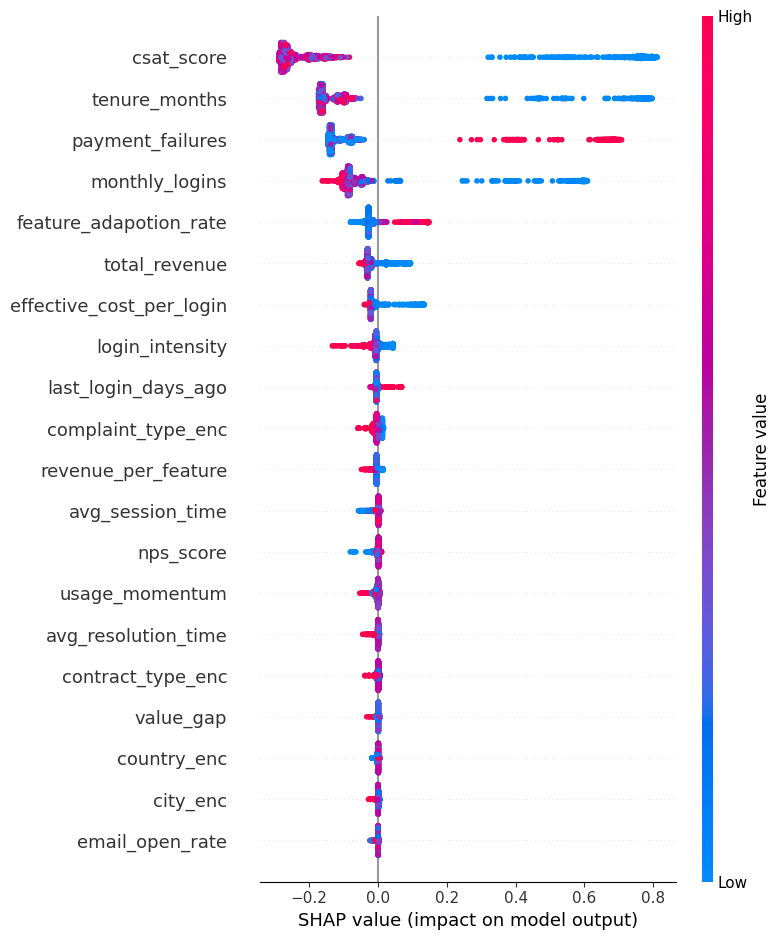

In [32]:
explainer = shap.TreeExplainer(final_xgb)

shap_values = explainer.shap_values(X_test_sel)

shap.summary_plot(shap_values, X_test_sel)

In [33]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train_sel),
    feature_names = X_train_sel.columns, 
    class_names = ['0', '1'], 
    mode = 'classification'
)

idx = 0

exp = lime_explainer.explain_instance(
    data_row = X_test_sel.iloc[idx].values, 
    predict_fn = final_xgb.predict_proba,
    num_features = 32 
)

exp.show_in_notebook(show_table = True)

# Learning Curve **XGBoost**

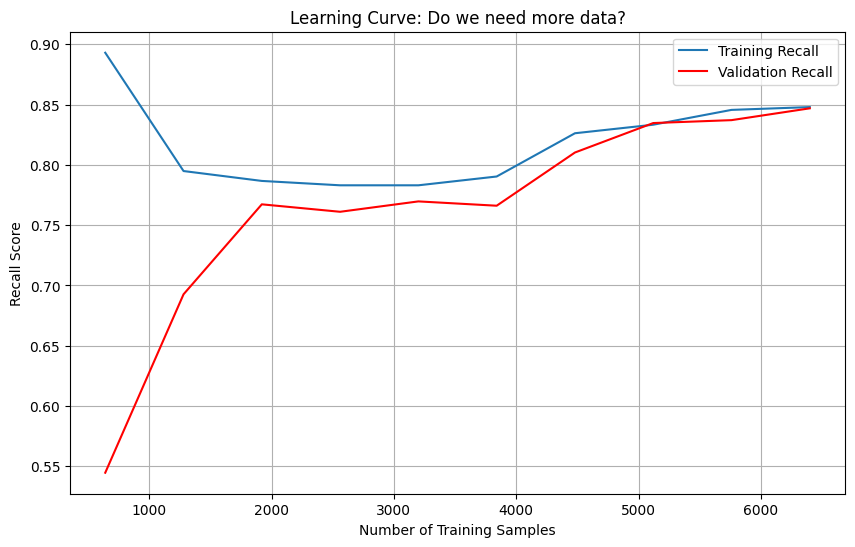

In [34]:
train_sizes, train_scores, test_scores = learning_curve(
    final_xgb, X_train_sel, y_train, cv = 5, scoring = 'recall',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Recall')
plt.plot(train_sizes, test_mean, label='Validation Recall', color='red')

plt.title('Learning Curve: Do we need more data?')
plt.xlabel('Number of Training Samples')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Learning Curve **LightGBM**

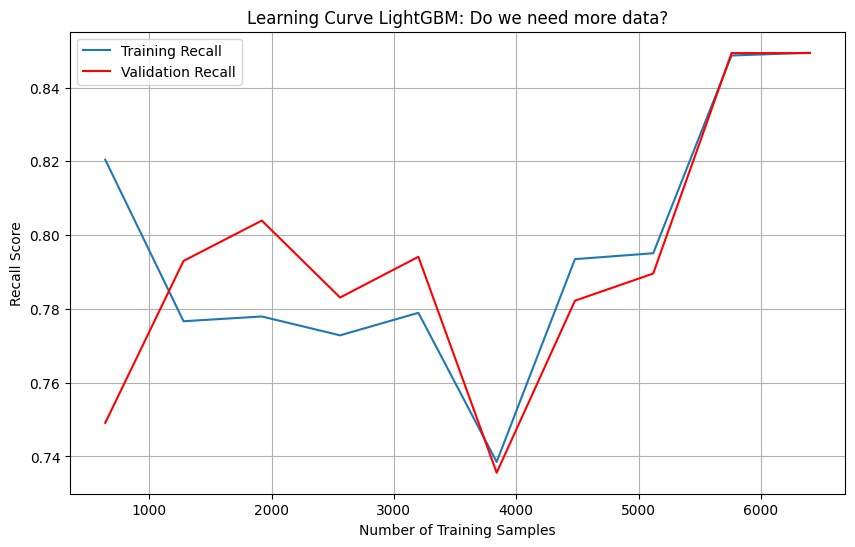

In [35]:
train_sizes, train_scores, test_scores = learning_curve(
    final_lgbm, X_train_sel, y_train, cv = 5, scoring = 'recall',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Recall')
plt.plot(train_sizes, test_mean, label='Validation Recall', color='red')

plt.title('Learning Curve LightGBM: Do we need more data?')
plt.xlabel('Number of Training Samples')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Saving Model

In [36]:
final_xgb.save_model("final_xgb.json")
print("XGBoost model saved")

XGBoost model saved


In [45]:
import joblib

global_mean = float(y_train.mean())

cat_cols = [
    "gender_enc",
    "country_enc",
    "city_enc",
    "customer_segment_enc",
    "signup_channel_enc",
    "contract_type_enc",
    "payment_method_enc",
    "discount_applied_enc",
    "complaint_type_enc",
    "survey_response_enc"
]


joblib.dump(target_encoding_maps, "/kaggle/working/target_encoding_maps.pkl")

cat_cols = [c.lower() for c in cat_cols]
joblib.dump(cat_cols, "cat_cols.pkl")

joblib.dump(global_mean, "/kaggle/working/global_mean.pkl")

selected_features = selected_features.str.lower()
joblib.dump(selected_features, "selected_features.pkl")


print("Saved artifacts:")
print("global_mean:", global_mean, type(global_mean))

Saved artifacts:
global_mean: 0.102125 <class 'float'>


# Learning Curve Analysis

The training and validation recall scores converge at approximately 0.85. The plateauing of the validation score indicates that the current dataset size is sufficient to capture the underlying patterns, and adding more data would likely yield diminishing returns. The minimal gap between training and validation performance suggests the model is robust and not suffering from significant overfitting.

# Final Thoughts

In the end, both XGBoost and LightGBM did a great job here. I intentionally tuned them to be aggressive because it is based on this assumptions "missing a churner is the worst-case scenario".

The result is solid. I might accidentally offer a retention discount to a few happy customers along the way, but successfully catching the vast majority of people who are actually at risk. It turns raw data into an early warning system that we can actually trust.